In [1]:
import torch

from Tokenizers import TokenizersConfig, Tokenizers

In [11]:
import torch
from BEATs import BEATs, BEATsConfig

# load the pre-trained checkpoints
checkpoint = torch.load('pt_dict/BEATs_iter3_plus_AS2M.pt')

cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])
BEATs_model.eval()

# Prepare your audio input
audio_input_16khz = torch.randn(1, 10000)  # Replace with your actual audio input
padding_mask = torch.zeros(1, 10000).bool()

# Extract the audio representation
representation = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]
representation

tensor([[[-0.1798, -0.5093, -0.5531,  ...,  0.0442, -0.1291,  0.1524],
         [ 0.1595, -0.2664, -0.1608,  ..., -0.0264,  0.2168,  0.3421],
         [ 0.4897, -0.2975,  0.2109,  ...,  0.2189, -0.1848,  0.2020],
         ...,
         [-0.0218,  0.3705,  0.8110,  ..., -0.2321, -0.3777, -0.0088],
         [ 0.1555,  0.2820,  0.6876,  ...,  0.0380, -0.4488,  0.0593],
         [ 0.1959, -0.0671, -0.1170,  ...,  0.1452, -0.5554,  0.1522]]],
       grad_fn=<TransposeBackward0>)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import torchaudio as ta
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from tqdm.notebook import tqdm
from resemblyzer import VoiceEncoder, preprocess_wav, normalize_volume, trim_long_silences
from pathlib import Path
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy.io import wavfile

In [3]:
QUERY_ROOT = "/mnt/gestalt/home/ddmanddman/moisesdb/npyq"
BEATS_ROOT = "/mnt/gestalt/home/ddmanddman/moisesdb/beats"

In [10]:
query_files = glob.glob(os.path.join(QUERY_ROOT, "**", "*.query-10s.npy"), recursive=True)
len(query_files)

4241

In [29]:
# Move the BEATs model to GPU
BEATs_model = BEATs_model.cuda()

for query_file in query_files:
    
    wav = np.load(query_file)
    wav = np.mean(wav, axis=0)
    wav = torch.tensor(wav, dtype=torch.float32).unsqueeze(0).cuda()
    
    padding_mask = torch.zeros(1, wav.shape[1]).bool().cuda()  # Move padding mask to GPU
    
    # Encoder
    embed = BEATs_model.extract_features(wav, padding_mask=padding_mask)[0]

    # Detach the tensor from the computation graph and convert it to a NumPy array
    embed_np = embed.detach().cpu().numpy()  # Move to CPU before converting to NumPy

    # Define the output path for saving the embedding
    resemb_path = query_file.replace(".query-10s.npy", ".beats.npy").replace(QUERY_ROOT, BEATS_ROOT)

    # Create the necessary directories if they do not exist
    os.makedirs(os.path.dirname(resemb_path), exist_ok=True)
    
    # Save the embedding as a numpy file
    np.save(resemb_path, embed_np)

Exception ignored in: <function tqdm.__del__ at 0x7ff11e10b1c0>
Traceback (most recent call last):
  File "/home/ddmanddman/miniconda3/envs/py310_env/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/ddmanddman/miniconda3/envs/py310_env/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [4]:
passts = glob.glob(os.path.join(BEATS_ROOT, "**", "*.beats.npy"), recursive=True)

passt_data = []
stem_data = []

for passt_file in passts:
    passt = np.load(passt_file)
    passt_data.append(passt)

    stem = passt_file.split("/")[-1].split(".")[0]

    stem_data.append(stem)

In [5]:
len(passt_data)
passt_data[0]

array([[[-0.4935442 ,  0.52148104,  0.55734783, ...,  0.01564839,
         -0.23553613,  0.07423037],
        [-0.214008  ,  0.17687157,  0.178147  , ..., -0.13233125,
          0.52168363,  0.3199284 ],
        [-0.15193284, -0.03219183,  0.15020935, ...,  0.19549958,
          0.05799552,  0.2621332 ],
        ...,
        [ 0.4382316 ,  0.43565622, -0.05060689, ...,  0.01416701,
          0.51998454, -0.06835855],
        [ 0.655144  ,  0.49378267, -0.16755341, ...,  0.01812634,
          0.62756217, -0.21042903],
        [ 0.5068329 ,  0.52318317,  0.10845391, ..., -0.557531  ,
          0.75078076, -0.3343244 ]]], dtype=float32)

In [6]:
passt_data = np.stack(passt_data)
passt_data.shape

(4241, 1, 1376, 768)

In [7]:
passt_data = passt_data.squeeze(1)
passt_data.shape

(4241, 1376, 768)

In [8]:
passt_data = passt_data.mean(axis=1)
passt_data.shape

(4241, 768)

In [9]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)

tsne_data = tsne.fit_transform(passt_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4241 samples in 0.002s...
[t-SNE] Computed neighbors for 4241 samples in 0.377s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4241
[t-SNE] Computed conditional probabilities for sample 2000 / 4241
[t-SNE] Computed conditional probabilities for sample 3000 / 4241
[t-SNE] Computed conditional probabilities for sample 4000 / 4241
[t-SNE] Computed conditional probabilities for sample 4241 / 4241
[t-SNE] Mean sigma: 1.397197
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.940742
[t-SNE] KL divergence after 1000 iterations: 0.900531


In [10]:
FINE_LEVEL_INSTRUMENTS = {
    "lead_male_singer",
    "lead_female_singer",
    "human_choir",
    "background_vocals",
    "other_vocals",
    "bass_guitar",
    "bass_synthesizer",
    "contrabass_double_bass",
    "tuba",
    "bassoon",
    "snare_drum",
    "toms",
    "kick_drum",
    "cymbals",
    "overheads",
    "full_acoustic_drumkit",
    "drum_machine",
    "hihat",
    "fx",
    "click_track",
    "clean_electric_guitar",
    "distorted_electric_guitar",
    "lap_steel_guitar_or_slide_guitar",
    "acoustic_guitar",
    "other_plucked",
    "atonal_percussion",
    "pitched_percussion",
    "grand_piano",
    "electric_piano",
    "organ_electric_organ",
    "synth_pad",
    "synth_lead",
    "other_sounds",
    "violin",
    "viola",
    "cello",
    "violin_section",
    "viola_section",
    "cello_section",
    "string_section",
    "other_strings",
    "brass",
    "flutes",
    "reeds",
    "other_wind",
}

COARSE_LEVEL_INSTRUMENTS = {
    "vocals",
    "bass",
    "drums",
    "guitar",
    "other_plucked",
    "percussion",
    "piano",
    "other_keys",
    "bowed_strings",
    "wind",
    "other",
}

COARSE_TO_FINE = {
    "vocals": [
        "lead_male_singer",
        "lead_female_singer",
        "human_choir",
        "background_vocals",
        "other_vocals",
    ],
    "bass": [
        "bass_guitar",
        "bass_synthesizer",
        "contrabass_double_bass",
        "tuba",
        "bassoon",
    ],
    "drums": [
        "snare_drum",
        "toms",
        "kick_drum",
        "cymbals",
        "overheads",
        "full_acoustic_drumkit",
        "drum_machine",
        "hihat",
    ],
    "other": ["fx", "click_track"],
    "guitar": [
        "clean_electric_guitar",
        "distorted_electric_guitar",
        "lap_steel_guitar_or_slide_guitar",
        "acoustic_guitar",
    ],
    "other_plucked": ["other_plucked"],
    "percussion": ["atonal_percussion", "pitched_percussion"],
    "piano": ["grand_piano", "electric_piano"],
    "other_keys": ["organ_electric_organ", "synth_pad", "synth_lead", "other_sounds"],
    "bowed_strings": [
        "violin",
        "viola",
        "cello",
        "violin_section",
        "viola_section",
        "cello_section",
        "string_section",
        "other_strings",
    ],
    "wind": ["brass", "flutes", "reeds", "other_wind"],
}

COARSE_TO_FINE = {k: set(v) for k, v in COARSE_TO_FINE.items()}
FINE_TO_COARSE = {k: kk for kk, v in COARSE_TO_FINE.items() for k in v}

ALL_LEVEL_INSTRUMENTS = COARSE_LEVEL_INSTRUMENTS.union(FINE_LEVEL_INSTRUMENTS)

In [11]:
tsne_data = pd.concat([pd.DataFrame(tsne_data, columns=["x", "y"]), pd.Series(stem_data, name="stem")], axis=1)

In [12]:
tsne_data["coarse"] = tsne_data["stem"].apply(lambda x: FINE_TO_COARSE[x] if x in FINE_LEVEL_INSTRUMENTS else x)

<Axes: xlabel='x', ylabel='y'>

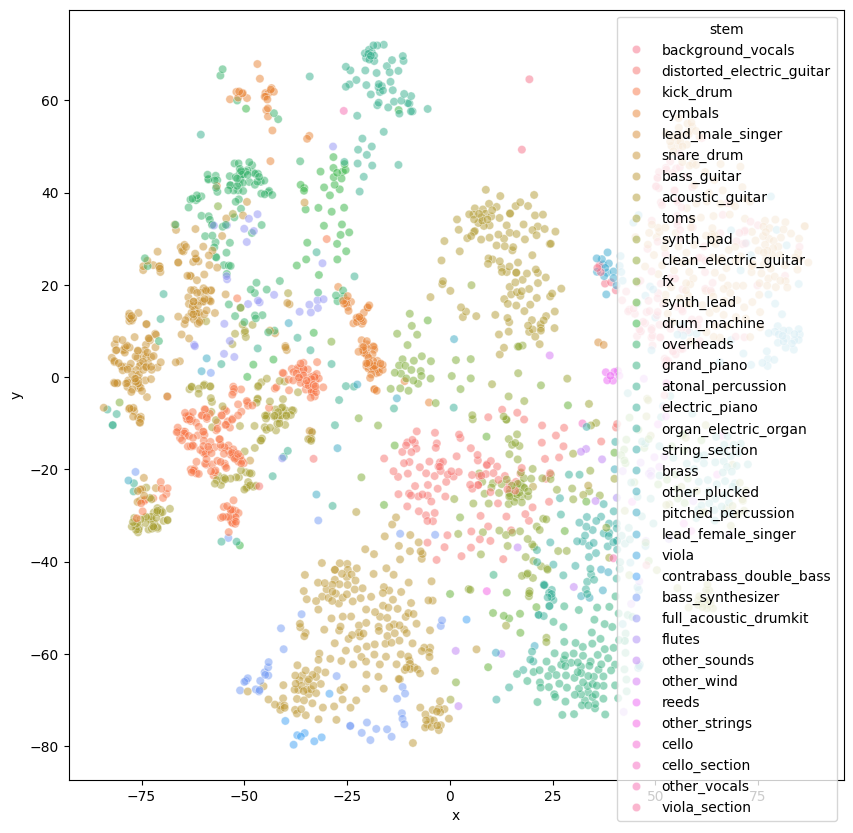

In [13]:
tsne_fine = tsne_data[tsne_data["stem"].isin(FINE_LEVEL_INSTRUMENTS)]

plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_fine, x="x", y="y", hue="stem", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

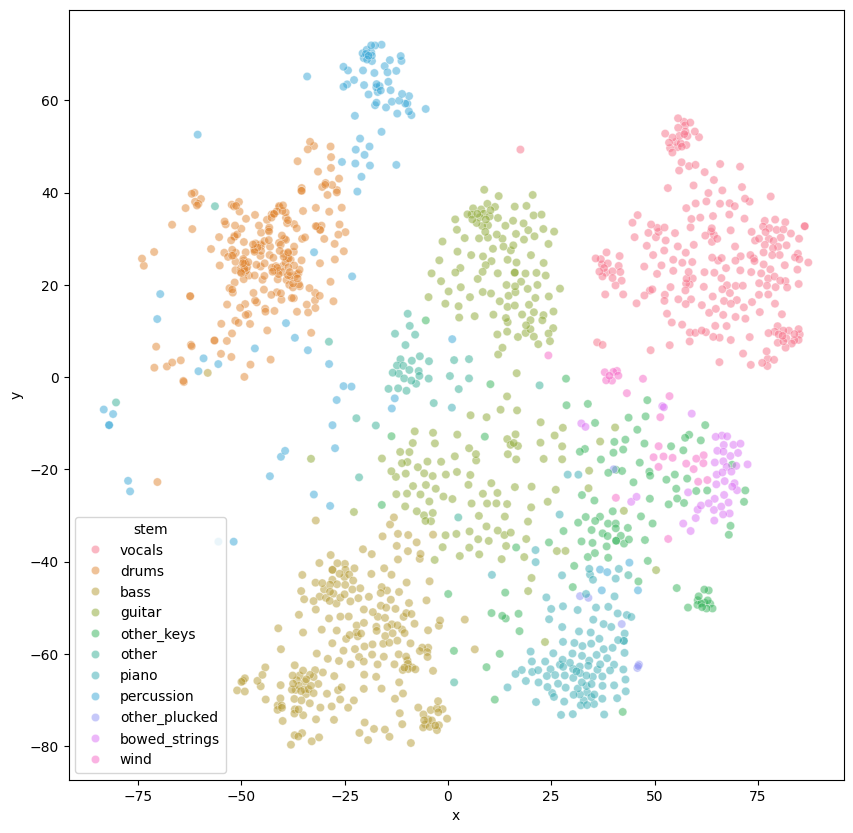

In [14]:
tsne_coarse = tsne_data[tsne_data["stem"].isin(COARSE_LEVEL_INSTRUMENTS)]

plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_coarse, x="x", y="y", hue="stem", alpha=0.5)

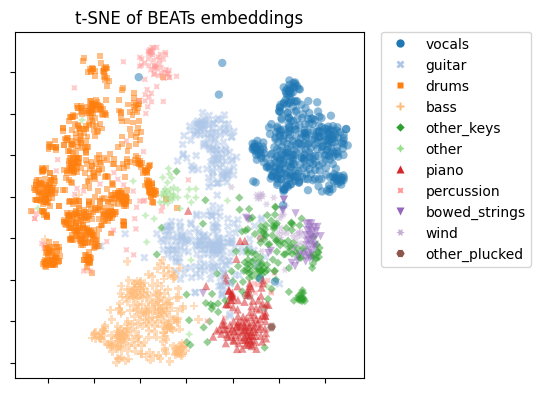

In [16]:
tsne_fine_coarse = tsne_data[tsne_data["stem"].isin(FINE_LEVEL_INSTRUMENTS)]

f, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
sns.scatterplot(data=tsne_fine_coarse,
                x="x", y="y",
                hue="coarse",
                edgecolor="none",
                alpha=0.5,
                style="coarse",
                palette="tab20",
                ax=ax
        )

ax.set(
    xlabel=None,
    ylabel=None,
    title="t-SNE of BEATs embeddings",
    xticklabels=[],
    yticklabels=[]
)

leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for lh in leg.legend_handles:
    lh.set_alpha(1)

plt.show()

In [17]:
ALLOWED_INSTRUMENT = [
      "drums",
      "lead_male_singer",
      "lead_female_singer",
      # "human_choir",
      "background_vocals",
      # "other_vocals",
      "bass_guitar",
      "bass_synthesizer",
      # "contrabass_double_bass",
      # "tuba",
      # "bassoon",
      "fx",
      "clean_electric_guitar",
      "distorted_electric_guitar",
      # "lap_steel_guitar_or_slide_guitar",
      "acoustic_guitar",
      # "other_plucked",
      "pitched_percussion",
      "grand_piano",
      "electric_piano",
      "organ_electric_organ",
      "synth_pad",
      "synth_lead",
      # "violin",
      # "viola",
      # "cello",
      # "violin_section",
      # "viola_section",
      # "cello_section",
      "string_section",
      # "other_strings",
      "brass",
      # "flutes",
      "reeds",
      # "other_wind"
  ]

allowed_instruments_dtype = pd.CategoricalDtype(categories=ALLOWED_INSTRUMENT, ordered=True)

In [18]:
short_stem = {
    "drums": "Drums",
  "lead_male_singer": "Lead M. Vox",
  "lead_female_singer": "Lead F. Vox",
  # "human_choir",
  "background_vocals": "Bg. Vox",
  # "other_vocals",
  "bass_guitar": "Bass Gtr.",
  "bass_synthesizer": "Bass Synth",
  # "contrabass_double_bass",
  # "tuba",
  # "bassoon",
  "fx": "Fx",
  "clean_electric_guitar": "Clean. E. Gtr.",
  "distorted_electric_guitar": "Dist. E. Gtr.",
  # "lap_steel_guitar_or_slide_guitar",
  "acoustic_guitar": "A. Gtr",
  "other_plucked": "Other Plucked",
  "pitched_percussion": "Pitched Perc.",
  "grand_piano": "Grand Piano",
  "electric_piano": "E. Piano",
  "organ_electric_organ": "Organ",
  "synth_pad": "Synth Pad",
  "synth_lead": "Synth Lead",
  # "violin",
  # "viola",
  # "cello",
  # "violin_section",
  # "viola_section",
  # "cello_section",
  "string_section": "Str. Sect.",
  "other_strings": "Other Str.",
  "brass": "Brass",
  # "flutes",
  "reeds": "Reeds",
  "other_wind": "Other Wind"
}

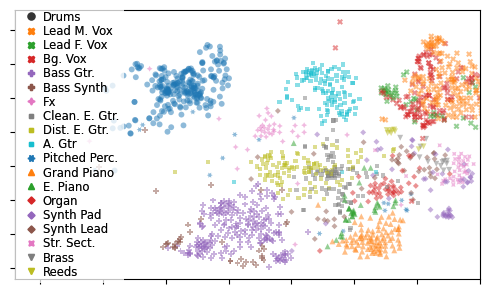

In [19]:
tsne_allowed = tsne_data[tsne_data["stem"].isin(ALLOWED_INSTRUMENT)].copy()

tsne_allowed["stem"] = tsne_allowed["stem"].astype(allowed_instruments_dtype)


f, ax = plt.subplots(1, 1, figsize=(6, 3.5))

sns.scatterplot(data=tsne_allowed,
                x="x", y="y",
                hue="stem",
                edgecolor="none",
                alpha=0.5,
                size=1,
                style="coarse",
                palette="tab10",
                ax=ax
        )

ax.set(
    xlabel=None,
    ylabel=None,
    xticklabels=[],
    yticklabels=[]
)

h, l = ax.get_legend_handles_labels()

stem_to_color = {ll: hh.get_markerfacecolor() for hh, ll in zip(h, l)}
coarse_to_marker = {ll: hh.get_marker() for hh, ll in zip(h, l)}


newh1 = []
newl1 = []

newh2 = []
newl2 = []

centroids = tsne_allowed.groupby("stem")[["x", "y"]].mean()

n_stems = len(ALLOWED_INSTRUMENT)

for stem in ALLOWED_INSTRUMENT:
    coarse_stem = FINE_TO_COARSE[stem] if stem in FINE_LEVEL_INSTRUMENTS else stem

    if True:
    #if centroids.loc[stem, "x"] < 0 or len(newh2) >= n_stems // 2:
        newh1.append(plt.Line2D([0], [0],
                                marker=coarse_to_marker[coarse_stem],
                                color=stem_to_color[stem],
                                markersize=5,
                                linestyle="None"))
        newl1.append(short_stem[stem])
    else:
        newh2.append(plt.Line2D([0], [0],
                                marker=coarse_to_marker[coarse_stem],
                                color=stem_to_color[stem],
                                markersize=5,
                                linestyle="None"))
        newl2.append(short_stem[stem])

ax.get_legend().remove()

l1 = plt.legend(newh1, newl1, loc="center left", borderaxespad=0., fontsize="small",
                frameon=True, handletextpad=0., columnspacing=0.8, labelspacing=0.1,
                framealpha=0.5, edgecolor="none")

ax.add_artist(l1)
# ax.add_artist(l2)

ax.set(xlim=[-110, 75])

centroids = tsne_allowed.groupby("stem")[["x", "y"]].mean()

plt.savefig("beats.pdf", bbox_inches="tight")

plt.show()